<a href="https://colab.research.google.com/github/choiwinner/LangGraph/blob/main/LG_Hierarchical_Agent_Teams_Old_20241128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://langchain-ai.github.io/langgraph/tutorials/

https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/

**Hierarchical Agent Teams¶**

In our previous example (Agent **Supervisor** [link text](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor)), we introduced the concept of a single [supervisor node](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) to route work between different worker nodes.

이전의 예(에이전트 감독자)에서 우리는 여러 작업자 노드 간에 작업을 라우팅하기 위해 단일 감독자 supervisor 노드의 개념을 도입했습니다.


But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

하지만 단일 작업자의 작업이 너무 복잡해지면 어떨까요? 작업자 수가 너무 많아지면 어떨까요?


For some applications, the system may be more effective if work is distributed hierarchically.

일부 애플리케이션의 경우 작업을 계층적으로 분산하면 시스템이 더 효과적일 수 있습니다.


You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

다른 하위 그래프를 구성하고 중간 감독자 supervisor와 함께 최상위 감독자 supervisor를 만들어서 이를 수행할 수 있습니다.


To do this, let's build a simple research assistant! The graph will look something like the following:

이를 위해 간단한 연구 조수 research assistant 를 만들어 보겠습니다! 그래프는 다음과 같습니다.


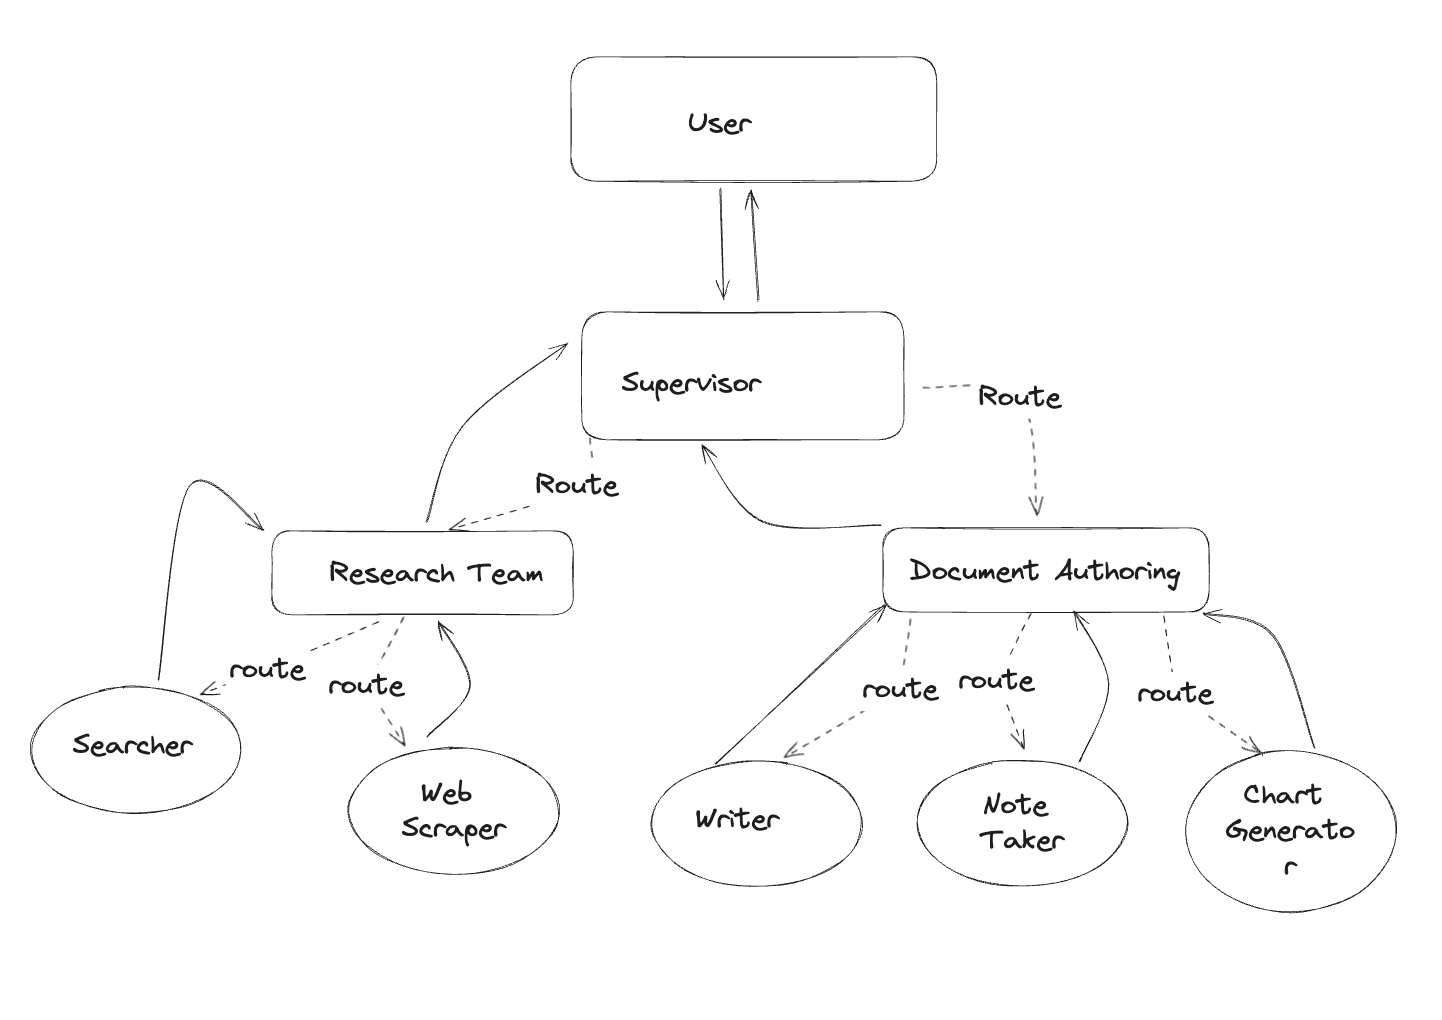

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

이 노트북은 Wu 등이 쓴 [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155) 논문에서 영감을 받았습니다. 이 노트북의 나머지 부분에서는 다음을 수행합니다.

1. Define the agents' tools to access the web and write files

   웹에 액세스하고 파일을 쓰기 위한 에이전트 도구 정의


2. Define some utilities to help create the graph and agents

   그래프와 에이전트를 만드는 데 도움이 되는 유틸리티 정의

3. Create and define each team (web research + doc writing)

   각 팀(웹 리서치 + 문서 작성) 생성 및 정의

4. Compose everything together.

   모든 것을 함께 구성.

**Setup¶**

First, let's install our required packages and set our API keys

먼저, 필수 패키지를 설치하고 API 키를 설정해 보겠습니다.

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental langchain_openai

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········
Please provide your TAVILY_API_KEY··········


Set up [LangSmith](https://smith.langchain.com/) for LangGraph development


Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started [here](https://docs.smith.langchain.com/).

LangSmith에 가입하여 문제를 빠르게 발견하고 LangGraph 프로젝트의 성능을 개선하세요. LangSmith를 사용하면 추적 데이터를 사용하여 LangGraph로 빌드한 LLM 앱을 디버깅, 테스트 및 모니터링할 수 있습니다. 여기에서 시작하는 방법에 대해 자세히 알아보세요.

**Create Tools¶**

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

각 팀은 하나 이상의 도구를 가진 하나 이상의 에이전트로 구성됩니다. 아래에서 다른 팀에서 사용할 모든 도구를 정의합니다.

We'll start with the research team.

연구 research 팀부터 시작하겠습니다.



**ResearchTeam tools**


The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

연구팀은 검색 엔진과 URL 스크래퍼를 사용하여 웹에서 정보를 찾을 수 있습니다. 아래에 추가 기능을 추가하여 팀 성과를 높이세요!

In [ ]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

API Reference: WebBaseLoader | TavilySearchResults | tool

https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html

https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html

https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html



**Document writing team tools**


Next up, we will give some tools for the doc writing team to use. We define some bare-bones file-access tools below.

다음으로, 문서 작성 팀이 사용할 수 있는 몇 가지 도구를 제공합니다. 아래에서 몇 가지 기본적인 파일 액세스 도구를 정의합니다.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

이렇게 하면 에이전트가 파일 시스템에 액세스할 수 있지만 안전하지 않을 수 있습니다. 또한 성능을 위해 도구 설명을 최적화하지 않았습니다.

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

API Reference: PythonREPL

https://python.langchain.com/api_reference/experimental/utilities/langchain_experimental.utilities.python.PythonREPL.html


**Helper Utilities¶**

We are going to create a few utility functions to make it more concise when we want to:

우리는 다음과 같은 경우에 더 간결하게 만들기 위해 몇 가지 유틸리티 함수를 만들 것입니다.

1. Create a worker agent.

   워커 에이전트를 만듭니다.

2. Create a supervisor for the sub-graph.

   서브 그래프에 대한 슈퍼바이저를 만듭니다.


These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

이렇게 하면 마지막에 그래프 구성 코드가 간소화되어 무슨 일이 일어나고 있는지 더 쉽게 볼 수 있습니다.

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, trim_messages


# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        # next: Literal[*options]
        next: Union[Literal["FINISH"], str]
        # next: Literal["FINISH", "search", "web_scraper"]
        # next: str

    def supervisor_node(state: MessagesState) -> MessagesState:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        next_ = response["next"]
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node

API Reference: BaseChatModel | HumanMessage | trim_messages | StateGraph | START | END

https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html

https://python.langchain.com/api_reference/core/messages/langchain_core.messages.human.HumanMessage.html

https://python.langchain.com/api_reference/core/messages/langchain_core.messages.utils.trim_messages.html

https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph

https://langchain-ai.github.io/langgraph/reference/constants/#langgraph.constants.START

https://langchain-ai.github.io/langgraph/reference/constants/#langgraph.constants.END



**Define Agent Teams¶**

Now we can get to define our hierarchical teams. "Choose your player!"

이제 계층적 팀을 정의할 수 있습니다. "플레이어를 선택하세요!"


Research Team¶

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

연구팀은 검색 에이전트와 웹 스크래핑 "research_agent"를 두 개의 작업자 노드로 갖게 됩니다. 이것들과 팀 감독자를 만들어 보겠습니다.

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from typing import Union

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: AgentState) -> AgentState:
    result = search_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="search")
        ]
    }


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: AgentState) -> AgentState:
    result = web_scraper_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="web_scraper")
        ]
    }


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

API Reference: HumanMessage | ChatOpenAI | create_react_agent

https://python.langchain.com/api_reference/core/messages/langchain_core.messages.human.HumanMessage.html

https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html

https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

이제 필요한 구성 요소를 만들었으므로 상호 작용을 정의하는 것은 쉽습니다. 팀 그래프에 노드를 추가하고 전환 기준을 결정하는 에지를 정의합니다.

In [ ]:
research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

# Define the control flow
research_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("web_scraper", "supervisor")
# Add the edges where routing applies
research_builder.add_conditional_edges("supervisor", lambda state: state["next"])

research_graph = research_builder.compile()

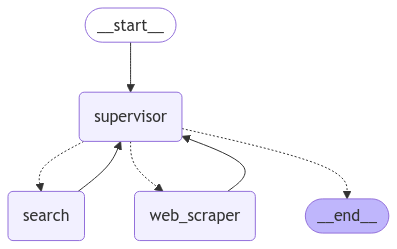

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

우리는 이 팀에 직접 일을 줄 수 있습니다. 아래에서 시도해 보세요.

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s "The Eras Tour" began in March 2023 and will continue into 2024. The tour includes a variety of international dates, with stops planned in North America, Latin America, Asia, Australia, and Europe.\n\nUpcoming dates in 2024 include:\n\n- **February 2024**: Tokyo, Japan\n- **March 2024**: Singapore\n- **May 2024**: Paris, France; Stockholm, Sweden; Lisbon, Portugal; Madrid, Spain\n- **June 2024**: Lyon, France; Edinburgh, United Kingdom; Liverpool, United Kingdom; Cardiff, United Kingdom; London, United Kingdom; Dublin, Ireland\n- **July 2024**: Amsterdam, Netherlands; Zürich, Switzerland; Milan, Italy; Gelsenkirchen, Germany; Hamburg, Germany; Munich, Germany\n- **August 2024**: Warsaw, Poland; Vienna, Austria; London, United Kingdom\n\nThe tour is set to conclude on November 23, 2024, in Toronto, Canada. Please check official sources or ticket platforms for the most current tour dates

**Document Writing Team¶**

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

아래와 같은 접근 방식을 사용하여 문서 작성 팀을 만드세요. 이번에는 각 에이전트에게 다른 파일 작성 도구에 대한 액세스 권한을 부여합니다.


Note that we are giving file-system access to our agent here, which is not safe in all cases.

여기서는 에이전트에게 파일 시스템 액세스 권한을 부여하고 있는데, 이는 모든 경우에 안전하지 않습니다.

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: AgentState) -> AgentState:
    result = doc_writer_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="doc_writer")
        ]
    }


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: AgentState) -> AgentState:
    result = note_taking_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="note_taker")
        ]
    }


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: AgentState) -> AgentState:
    result = chart_generating_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="chart_generator")
        ]
    }


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

With the objects themselves created, we can form the graph.

객체 자체가 생성되면 그래프를 형성할 수 있습니다.

In [ ]:
# Create the graph here
paper_writing_builder = StateGraph(AgentState)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

# Define the control flow
paper_writing_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
paper_writing_builder.add_edge("doc_writer", "supervisor")
paper_writing_builder.add_edge("note_taker", "supervisor")
paper_writing_builder.add_edge("chart_generator", "supervisor")
# Add the edges where routing applies
paper_writing_builder.add_conditional_edges("supervisor", lambda state: state["next"])

paper_writing_graph = paper_writing_builder.compile()

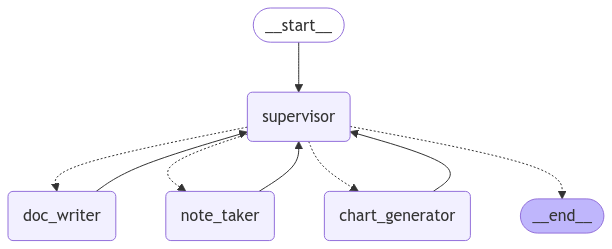

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about dogs and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about dogs has been created and saved as "dogs_poem_outline.txt."', additional_kwargs={}, response_metadata={}, name='note_taker', id='c2d9fcee-e2e6-46bd-afd8-67d8f3a686af')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The poem titled "Ode to Our Canine Companions" has been written and saved as "ode_to_our_canine_companions.txt."', additional_kwargs={}, response_metadata={}, name='doc_writer', id='3ffb1fab-6ba6-4511-85bd-dde03af50b4e')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [ ]:
# 파일 경로 설정 (생성된 파일은 WORKING_DIRECTORY에 저장됨)
from pathlib import Path

outline_path = WORKING_DIRECTORY / "dogs_poem_outline.txt"
poem_path = WORKING_DIRECTORY / "ode_to_our_canine_companions.txt"

# Outline 파일 읽기
with outline_path.open("r") as file:
    outline_content = file.read()
print("Outline Content:")
print(outline_content)

# Poem 파일 읽기
with poem_path.open("r") as file:
    poem_content = file.read()
print("\nPoem Content:")
print(poem_content)


Outline Content:
Title: Ode to Our Canine Companions

I. Introduction 
   A. Opening line introducing the theme of dogs
   B. Brief mention of their diversity (different breeds, sizes, colors)

II. The Joy They Bring
   A. Description of playful behaviors
   B. Moments of happiness and laughter

III. Loyalty and Companionship
   A. Unwavering loyalty and trust
   B. Examples of companionship in everyday life

IV. Protection and Service
   A. Roles in protection and guarding
   B. Service dogs and their contributions

V. Emotional Support
   A. Comfort during tough times
   B. Stories of emotional connections

VI. Conclusion
   A. Reflection on the special bond between humans and dogs
   B. Closing line celebrating dogs

Poem Content:
Title: Ode to Our Canine Companions

In the world of wagging tails and boundless glee,  
Where colors and sizes dance with such spree,  
Dogs of all kinds, with hearts so true,  
Bring joy and laughter in all that they do.

Their playful antics, a sight to

**Add Layers¶**

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

이 디자인에서는 상향식 계획 정책을 시행합니다. 이미 두 개의 그래프를 만들었지만 두 그래프 간에 작업을 라우팅하는 방법을 결정해야 합니다.


We'll create a third graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

이전 두 그래프를 조정하기 위해 세 번째 그래프를 만들고, 이 최상위 상태가 다른 그래프 간에 어떻게 공유되는지 정의하기 위해 몇 가지 커넥터를 추가합니다.

In [ ]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

API Reference: BaseMessage

https://python.langchain.com/api_reference/core/messages/langchain_core.messages.base.BaseMessage.html


In [ ]:
def call_research_team(state: AgentState) -> AgentState:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentState) -> AgentState:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }


# Define the graph.
super_builder = StateGraph(AgentState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

# Define the control flow
super_builder.add_edge(START, "supervisor")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")
# Add the edges where routing applies
super_builder.add_conditional_edges("supervisor", lambda state: state["next"])
super_graph = super_builder.compile()

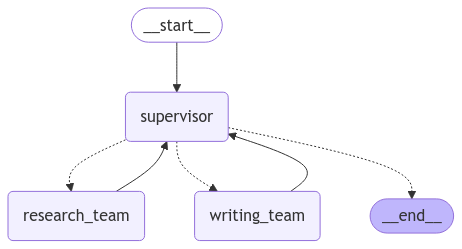

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        # ],*members
        ],
        "research_team": "Research team details here",  # research_team 명시
        "writing_team": "Writing team details here",    # writing_team 명시
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='**AI Agents: An Overview**\n\nAI agents are advanced software entities designed to autonomously execute tasks for users or systems, encompassing capabilities far beyond traditional Robotic Process Automation (RPA). AI agents are equipped with advanced functionalities such as natural language processing, strategic planning, and adaptability, enabling them to manage complex workflows, resolve real-time issues, and proactively interact with users. This marks a significant evolution from RPA, which typically focuses on simpler, repetitive tasks.\n\n**Market Growth and Adoption**\n\nThe AI agents market is anticipated to experience substantial growth, potentially reaching $47.1 billion by 2030. This surge is fueled by the increasing demand for efficient, AI-driven solutions capable of automating intricate operations and supporting data-informed decision-making across various industries. In th

In [ ]:
# 파일 경로 설정 (생성된 파일은 WORKING_DIRECTORY에 저장됨)
from pathlib import Path

outline_path = WORKING_DIRECTORY / "AI_Agents_Overview.txt"
poem_path = WORKING_DIRECTORY / "AI_Agents_Overview_Outline.txt"

# Outline 파일 읽기
with outline_path.open("r") as file:
    outline_content = file.read()
print("First File:")
print(outline_content)

# Poem 파일 읽기
with poem_path.open("r") as file:
    poem_content = file.read()
print("\nSecond File:")
print(poem_content)

First File:
**AI Agents: An Overview**

AI agents are advanced software entities designed to autonomously execute tasks for users or systems, encompassing capabilities far beyond traditional Robotic Process Automation (RPA). AI agents are equipped with advanced functionalities such as natural language processing, strategic planning, and adaptability, enabling them to manage complex workflows, resolve real-time issues, and proactively interact with users. This marks a significant evolution from RPA, which typically focuses on simpler, repetitive tasks.

**Market Growth and Adoption**

The AI agents market is anticipated to experience substantial growth, potentially reaching $47.1 billion by 2030. This surge is fueled by the increasing demand for efficient, AI-driven solutions capable of automating intricate operations and supporting data-informed decision-making across various industries. In this domain, North America is at the forefront due to its technological advancements, strong fin